In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import time
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

#Logistic regression

Implementation of **logistic regression** using the:
*   **gradient descent method**
*   **mini bach**
*   **squared gradients sum.**

mini bach and squared gradients sum are techniques to improve the model training results. Learning supports both stopping after reaching a given error and completing a given quantity


In [2]:
def sigmoid(beta):
    return 1 / (1 + np.exp(-beta))

def logistic_regression_mini_batch(X, y, batch_size=32, learning_rate=0.01, decay_rate=0.00001, max_iterations=1000, epsilon=1e-4):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    squared_gradients_sum = np.zeros(n_features)

    for iteration in range(max_iterations):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for batch_start in range(0, n_samples, batch_size):
            batch_end = min(batch_start + batch_size, n_samples)
            X_batch = X_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]

            prev_weights = np.copy(weights)
            predictions = sigmoid(np.dot(X_batch, weights))
            gradient = np.dot(X_batch.T, (y_batch - predictions))
            squared_gradients_sum = decay_rate * squared_gradients_sum + (1 - decay_rate) * gradient ** 2
            weights += (learning_rate / np.sqrt(squared_gradients_sum + epsilon)) * gradient

        if np.all(np.abs(weights - prev_weights) < epsilon):
            break

    return weights

def log_pred(X, weights):
    return np.round(sigmoid(np.dot(X, weights)))

**Metrics Implementation:**

In [3]:
def metrics(y_test, y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)

  TN = conf_matrix[0, 0]
  FP = conf_matrix[0, 1]
  FN = conf_matrix[1, 0]
  TP = conf_matrix[1, 1]

  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)

  return conf_matrix, sensitivity, specificity

Let's compare the model we created with the model from sklearn on synthetically generated data


In [4]:
X, y = make_classification(n_samples=2568, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=254468)

X = np.hstack((np.ones((X.shape[0], 1)), X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [5]:
times = []
for i in range(100):
  start = time.time()
  weights = logistic_regression_mini_batch(X_train, y_train)
  y_pred_anl = log_pred(X_test, weights)
  end = time.time()
  times.append(end - start)
  sum_time = sum(times)

print(f'it took {sum_time} seconds to perform the classification analytically 100 times')

it took 43.25986933708191 seconds to perform the classification analytically 100 times


In [6]:
class_0_indices = np.where(y_pred_anl == 0)[0]
class_1_indices = np.where(y_pred_anl == 1)[0]

class_0_anl = X_test[class_0_indices]
class_1_anl = X_test[class_1_indices]

In [7]:
max_iter = 1000
max_error = 1e-4
model = LogisticRegression(max_iter=max_iter, tol=max_error)

times = []
for i in range(100):
  start = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  end = time.time()
  times.append(end - start)
  sum_time = sum(times)

print(f'it took {sum_time} seconds to perform classification 100 times with sklearn')

it took 0.730964183807373 seconds to perform classification 100 times with sklearn


In [8]:
class_0_indices = np.where(y_pred == 0)[0]
class_1_indices = np.where(y_pred == 1)[0]

class_0 = X_test[class_0_indices]
class_1 = X_test[class_1_indices]

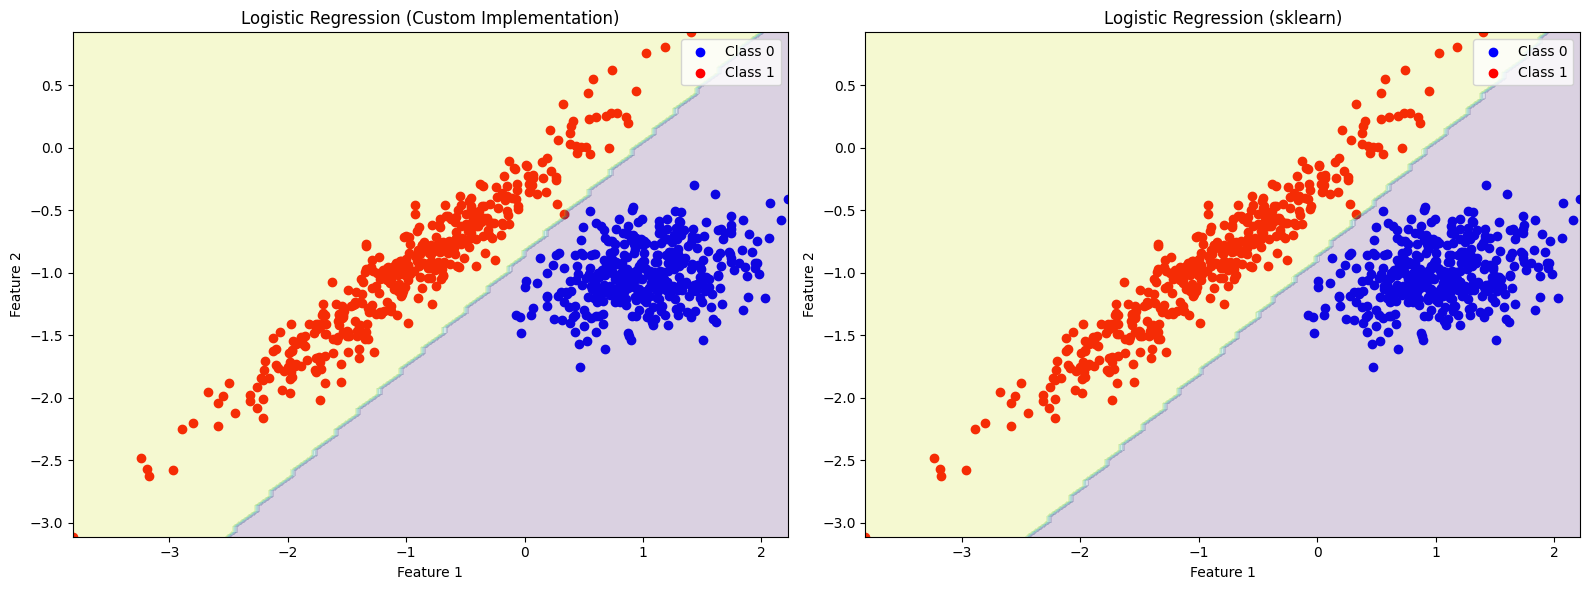

In [9]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(class_0_anl[:, 1], class_0_anl[:, 2], c='blue', label='Class 0')
plt.scatter(class_1_anl[:, 1], class_1_anl[:, 2], c='red', label='Class 1')

xx, yy = np.meshgrid(np.linspace(X_test[:,1].min(), X_test[:,1].max(), 100),
                     np.linspace(X_test[:,2].min(), X_test[:,2].max(), 100))
Z = log_pred(np.column_stack([np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]), weights)
Z = np.array(Z).reshape(1, -1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)

plt.title('Logistic Regression (Custom Implementation)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(class_0[:, 1], class_0[:, 2], c='blue', label='Class 0')
plt.scatter(class_1[:, 1], class_1[:, 2], c='red', label='Class 1')

Z = model.predict(np.column_stack([np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)

plt.title('Logistic Regression (sklearn)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred_anl)

print("Confusion Matrix (Custom Implementation):")
print(conf_matrix_anl)
print("Sensitivity:", sensitivity_anl)
print("Specificity:", specificity_anl)

Confusion Matrix (Custom Implementation):
[[379   6]
 [  1 385]]
Sensitivity: 0.9974093264248705
Specificity: 0.9844155844155844


In [11]:
conf_matrix, sensitivity, specificity = metrics(y_test, y_pred)

print("Confusion Matrix (sklearn):")
print(conf_matrix)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Confusion Matrix (sklearn):
[[379   6]
 [  1 385]]
Sensitivity: 0.9974093264248705
Specificity: 0.9844155844155844


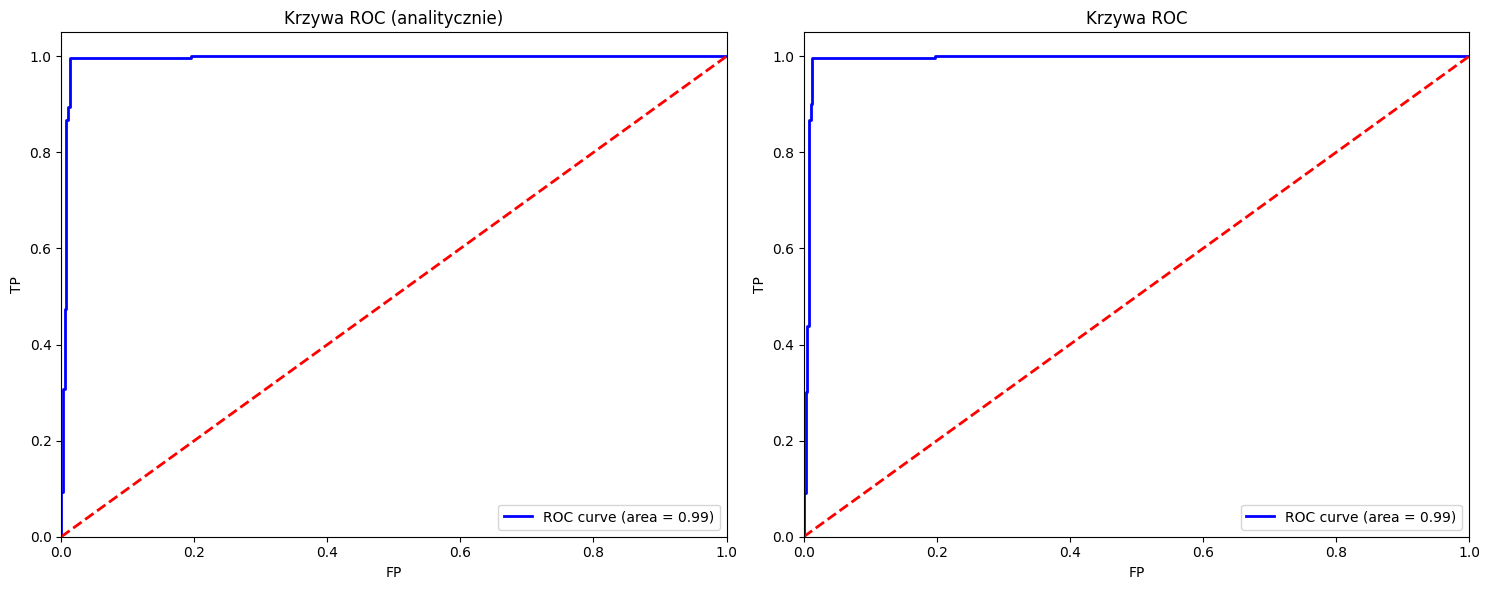

In [12]:
y_scores_anl = X_test @ weights

fpr_anl, tpr_anl, thresholds_anl = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('Krzywa ROC (analitycznie)')
plt.legend(loc="lower right")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.legend()

plt.tight_layout()
plt.show()

As you can see, both classifiers work the same. All data is correct. Therefore, time will be crucial here, thanks to which we will be able to conclude that the **classifier using sklearn** is more efficient. This is due to the implementation of mini_bach in our solution

Let's test our classifier on more difficult data generated with **make_moons**


In [22]:
X, y = make_moons(n_samples=2568, random_state=254468)

X = np.column_stack([np.ones(len(X)), X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [41]:
weights = logistic_regression_mini_batch(X_train, y_train)
y_pred_anl = log_pred(X_test, weights)

In [43]:
class_0_indices = np.where(y_pred_anl == 0)[0]
class_1_indices = np.where(y_pred_anl == 1)[0]

class_0_anl = X_test[class_0_indices]
class_1_anl = X_test[class_1_indices]

In [25]:
max_iter = 1000
max_error = 1e-4
model = LogisticRegression(max_iter=max_iter, tol=max_error)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
class_0_indices = np.where(y_pred == 0)[0]
class_1_indices = np.where(y_pred == 1)[0]

class_0 = X_test[class_0_indices]
class_1 = X_test[class_1_indices]

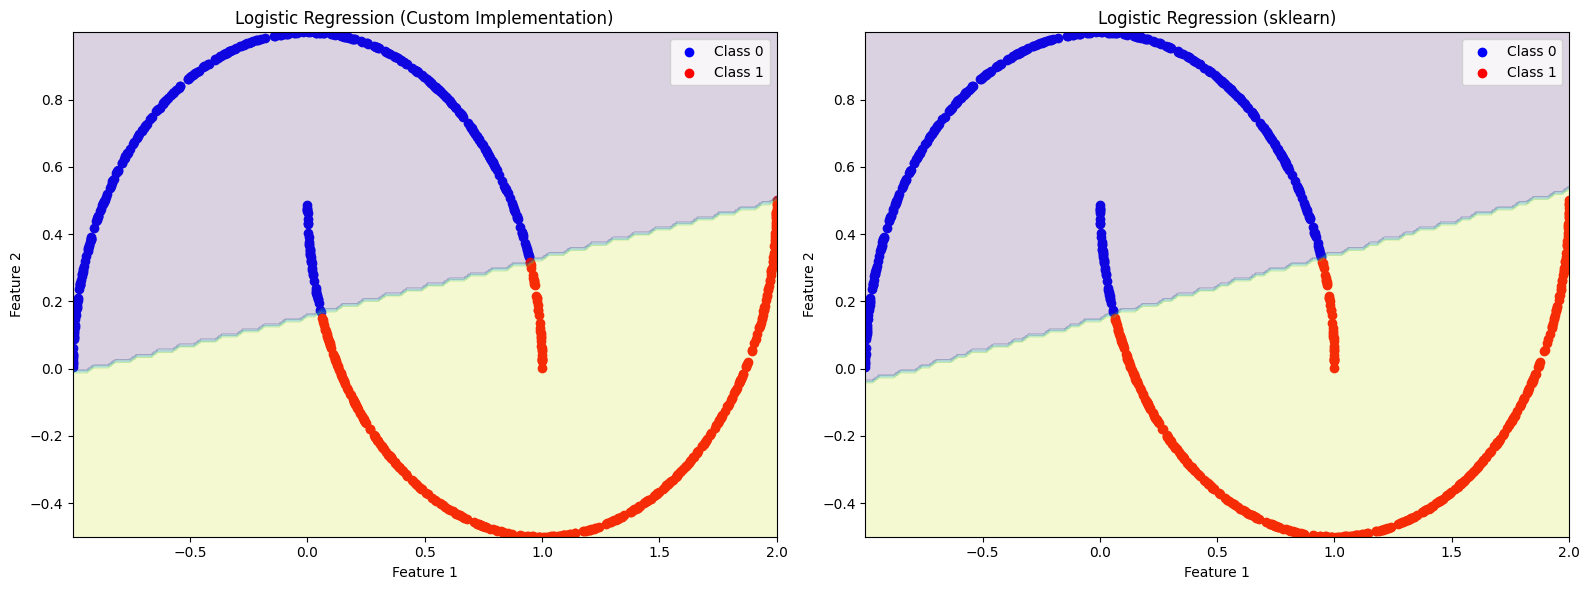

In [44]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(class_0_anl[:, 1], class_0_anl[:, 2], c='blue', label='Class 0')
plt.scatter(class_1_anl[:, 1], class_1_anl[:, 2], c='red', label='Class 1')

xx, yy = np.meshgrid(np.linspace(X_test[:,1].min(), X_test[:,1].max(), 100),
                     np.linspace(X_test[:,2].min(), X_test[:,2].max(), 100))
Z = log_pred(np.column_stack([np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]), weights)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)

plt.title('Logistic Regression (Custom Implementation)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(class_0[:, 1], class_0[:, 2], c='blue', label='Class 0')
plt.scatter(class_1[:, 1], class_1[:, 2], c='red', label='Class 1')


Z = model.predict(np.column_stack([np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)

plt.title('Logistic Regression (sklearn)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
conf_matrix_anl, sensitivity_anl, specificity_anl = metrics(y_test, y_pred_anl)

print("Confusion Matrix (Custom Implementation):")
print(conf_matrix_anl)
print("Sensitivity:", sensitivity_anl)
print("Specificity:", specificity_anl)

Confusion Matrix (Custom Implementation):
[[337  38]
 [ 41 355]]
Sensitivity: 0.8964646464646465
Specificity: 0.8986666666666666


In [46]:
conf_matrix, sensitivity, specificity = metrics(y_test, y_pred)

print("Confusion Matrix (sklearn):")
print(conf_matrix)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Confusion Matrix (sklearn):
[[337  38]
 [ 41 355]]
Sensitivity: 0.8964646464646465
Specificity: 0.8986666666666666


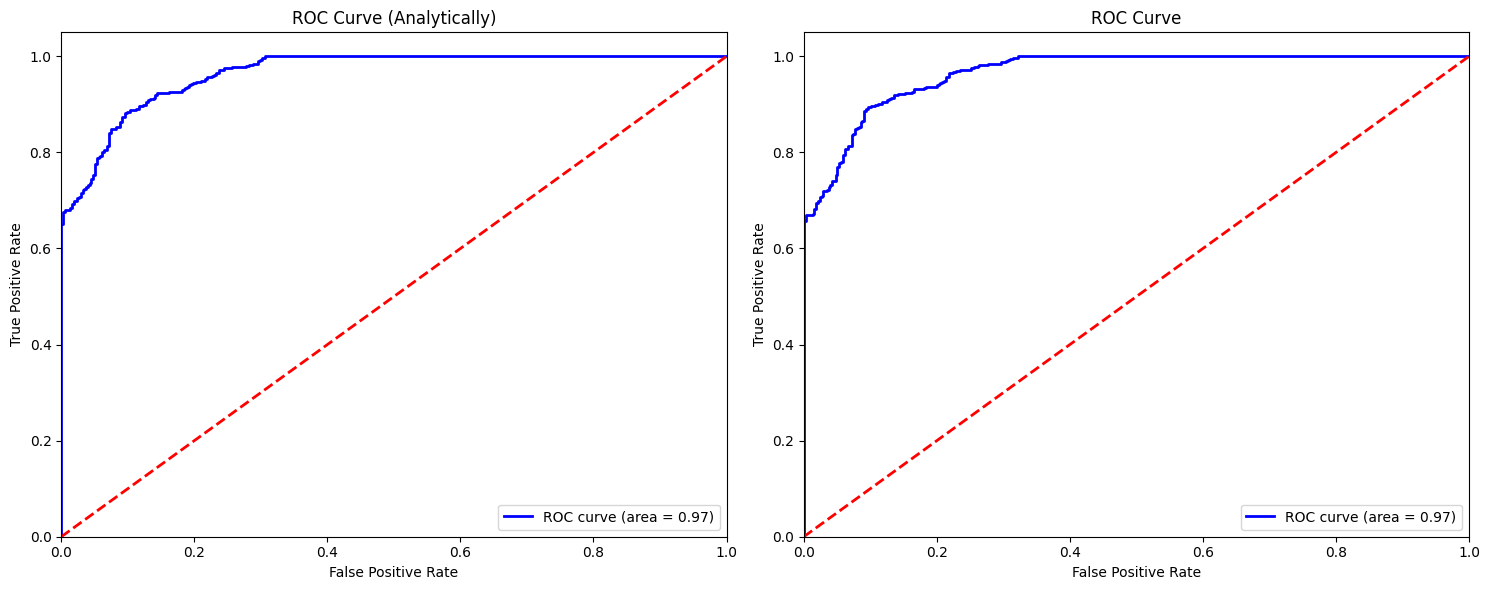

In [21]:
y_scores_anl = X_test @ weights

fpr_anl, tpr_anl, thresholds_anl = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Analytically)')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Both classifiers work identically. It is worth noting that the result of our own implementation may be different with each use because we use random data division in mini_bach.